In [ ]:
# default_exp samplers

# Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition
from qsam.simulators.chp import CHP
from qsam.fault_generators import Depolar

import numpy as np
import itertools as it

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES }

In [ ]:
#export
class Sampler:
    """Sampler base class"""
    
    def __init__(self, circuit, err_params):
        self.circuit = circuit
        self.n_qubits = circuit.n_qubits
        self.partitions = [partition(circuit, GATE_GROUPS[g]) for g in err_params.keys()]
        self.p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
        self.fault_gen = Depolar(n_ticks=len(circuit))

    def _sample(self, params):
        sim = CHP(self.n_qubits)
        fault_circuit = self.fault_gen.generate(self.partitions, params, type(self).__name__)
        return sim.run(self.circuit, fault_circuit)

    def _check_logical_failure(self, msmt):
        return 1 if msmt.items() <= self.circuit.failures.items() else 0

In [ ]:
#export
class DirectSampler(Sampler):
    """Direct Monte Carlo sampler"""

    def run(self, n_samples=100, var=math.Wilson_var):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0])) # one fail counter per p_phys

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(p_phys)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

In [ ]:
#hide
#export
def uniform_select(counts, *args, **kwargs):
    """Return index of least sampled SS"""
    # return np.argmin(counts)
    return counts.argmin()

def ERV_select(counts, fail_counts, Aw=1, var=math.Wilson_var, *args, **kwargs):
    """Return index of SS which yields maximum ERV"""

    p = fail_counts / counts # list of SS failure rates
    v = var(p, counts) # list of variances

    # prospective failure rates
    p_p = (fail_counts+1) / (counts+1) # next msmt yields +1 (i.e. 1)
    p_m = fail_counts / (counts+1) # next msmt yields -1 (i.e. 0)

    # prospective variances
    v_p = var(p_p, counts+1) 
    v_m = var(p_m, counts+1)

    # expectation value of prospective variances
    v_prop = p*v_p + (1-p)*v_m 

    # maximize difference (scaled by occurance prob)
    delta = Aw**2 * (v - v_prop)
    # return np.argmax(delta)
    return delta.argmax()

In [ ]:
#hide
#export
def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

def calc_subset_occurances(partitions, partition_weight_vecs, p_phys_mat):
    """Calculate 3D tensor of binom. coefficients for each partition"""
    
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phys_mat) for w_vec in partition_weight_vecs])
    Aws = np.product(Aws, axis=-1) # get list of Aw for each partition SS combination
    return Aws

In [ ]:
#export
class SubsetSampler(Sampler):
    """Monte Carlo subset sampler"""
    
    def __init__(self, circuit, err_params, w_params, subset_select_fn=uniform_select):
        super().__init__(circuit, err_params)
        self.subset_select_fn = subset_select_fn
                
        if 'w_max' in w_params:
            w_max_vec = w_params['w_max']
        elif 'p_max' in w_params and 'delta_max' in w_params:
            w_max_vec = [calc_w_max(p,d,len(par)) for p,d,par in zip(w_params['p_max'],w_params['delta_max'],self.partitions)]
        else:
            raise Exception(f"Cannot process setup parameters {w_params}.")
        
        # Not ideal: Calculate Aws for all w_vecs and later for w_vecs with exclusion. 
        w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec] # tuples of ranges upto w_max
        w_vecs = list(it.product( *w_upto_w_maxs )) # all weight vector combinations
        self.Aws_upper = 1 - np.sum(calc_subset_occurances(self.partitions, w_vecs, self.p_phys_mat), axis=0) # calc. upper bound for binomal weights
        
        w_exclude = w_params.get('w_exclude', set())
        w_exclude = set((w,) if type(w)==int else w for w in w_exclude) # convert ints to tuple for single-parameter case
        self.w_vecs = [w_vec for w_vec in it.product( *w_upto_w_maxs ) if w_vec not in w_exclude]
        self.Aws = calc_subset_occurances(self.partitions, self.w_vecs, self.p_phys_mat) # Aws with exclusion

        print(f"Setup sampling of partitions {list(err_params.keys())} with maximum fault weights {w_max_vec} and excluded weights {w_exclude}.")

            
    def run(self, n_samples=100, var=math.Wilson_var, p_phy_select=None):
        
        print(f"Start sampling of {n_samples} samples using {self.subset_select_fn.__name__} as subset selector.")
        
        cnts      = np.zeros((len(self.w_vecs))) + 1 # one virtual sample to avoid div0
        fail_cnts = np.zeros((len(self.w_vecs))) 
        
        if p_phy_select:
            Aw_select = calc_subset_occurances(self.partitions, self.w_vecs, np.array(p_phy_select))
        else:
            Aw_select = np.sum(self.Aws, axis=1)

        for i in range(n_samples):
            idx = self.subset_select_fn(cnts, fail_cnts, Aw=Aw_select) # TODO: Aw for ERV should be first selected Aw, not sum
            w_vec = self.w_vecs[idx]
            msmt = self._sample(w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
        pws = (fail_cnts / (cnts-1))[:,None]
        
        p_L_low = np.sum(self.Aws * pws, axis=0)
        p_L_up = p_L_low + self.Aws_upper
        std = math.std_sum(self.Aws, pws, n_samples, var)
        
        print(f"Finished sampling. Subset error rates:")
        print({w:tuple(np.round(p,3)) for w,p in zip(self.w_vecs,pws)})

        return p_L_up, p_L_low, std

Let's see how the samplers work. First we create some circuit to sample from. Let's choose a simple GHZ preparation flag circuit. This circuit produces the four-qubit GHZ state $|GHZ\rangle=\frac{1}{\sqrt{2}}(|0000\rangle+|1111\rangle)$ on qubits 0-3. The fifth qubit (qubit no. 4) is the flag which we measure to be either unchanged, i.e. $|0\rangle$, +1 (i.e. conventionally binary 0) if our prepared GHZ-state is error-free or if there is only a weight-1 error on the state (Note, we use **error** instead of **fault** to highlight that that we are talking about the **final faulty state**). If the flag measurement yield -1 (i.e. binary 1) we know that an error of weight larger than 1 occured on our final state, i.e. $|GHZ\rangle\rightarrow E_w|GHZ\rangle$, where $w\gt 1$ is the error-weight. Only these events we want to count as logical errors. Thus, let us first define the circuit and the physical error probabilities at which we want to sample logical error rates:

In [ ]:
from qsam.circuit import Circuit
import numpy as np

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

ghz.failures[((6,4),)] = '1' # define which measurement is a failure for this circuit

p = np.logspace(-3,0,10)

err_params = {'p': p}

Next, we create a sampler object and run it for a specified number of samples. Let's start with the `DirectSampler`:

In [ ]:
#slow
sam = DirectSampler(ghz, err_params)
p_L, std = sam.run(n_samples=10000)

Similarly, we can do the same sampling using the `SubsetSampler`. For this, we need to provide a `w_params` dictionary which contains either `p_max` and `delta_max` or `w_max` to specify the maximum partition weight up to which we want to include in the sampling. `delta_max` is the distance between these bounds at the `p_max` value. So, for large `p_max`, larger fault-weight subsets become relevant and in turn `delta_max` would increase if we didn't include those. Additionally, we can specify with `w_exclude` direct if we want to exclude partition weight subsets. We also note that the `run` method in this case gives us an upper and a lower bound on the logical error rate instead of a single `p_L` as before.

In [ ]:
#slow
w_params = {'w_max':[3], 'w_exclude': {0}}
# w_params = {'p_max': [0.1], 'delta_max': [0.1]}
sam = SubsetSampler(ghz, err_params, w_params, subset_select_fn=ERV_select)
p_L_up, p_L_low, ss_std = sam.run(n_samples=1000)

Setup sampling of partitions ['p'] with maximum fault weights [3] and excluded weights {(0,)}.
Start sampling of 1000 samples using ERV_select as subset selector.
Finished sampling. Subset error rates:
{(1,): (0.425,), (2,): (0.532,), (3,): (0.431,)}


Let's plot and compare the two:

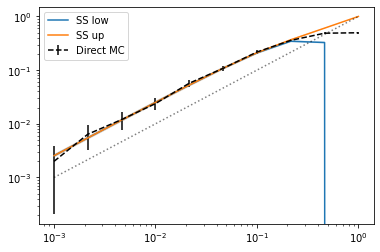

In [ ]:
#slow
#hide_input
import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std/2, p_L_low+ss_std/2, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std/2, p_L_up+ss_std/2, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

# Multi-parameter error models
Similarly, for a multi-parameter noise model all we have to do is specify the physical error rates for corresponding partitions and pass it to the sampler. Note that for now only two partitions are implemented (one for one-qubit gates and one for two-qubit gates).

In [ ]:
#slow
p1 = np.logspace(-3,0,10)
p2 = 0.5 * p1
err_params = {'p1': p1, 'p2': p2}
w_params = {'w_max':[1,3], 'w_exclude': {(0,0),}}

sam = SubsetSampler(ghz, err_params, w_params)
p_L_up, p_L_low, ss_std = sam.run(n_samples=1000)

sam = DirectSampler(ghz, err_params)
p_L, std = sam.run(n_samples=10000)

Setup sampling of partitions ['p1', 'p2'] with maximum fault weights [1, 3] and excluded weights {(0, 0)}.
Start sampling of 1000 samples using uniform_select as subset selector.
Finished sampling. Subset error rates:
{(0, 1): (0.476,), (0, 2): (0.476,), (0, 3): (0.455,), (1, 0): (0.0,), (1, 1): (0.531,), (1, 2): (0.49,), (1, 3): (0.528,)}


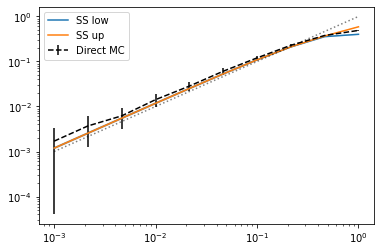

In [ ]:
#slow
#hide_input

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std/2, p_L_low+ss_std/2, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std/2, p_L_up+ss_std/2, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

# Subset sampling helper functions
> Collection functions to support subset sampling.

First, let's talk about how to decide which subset to sample from during subset sampling. The simplest strategy would be to always select the subset which was sampled least in order to sample uniformly from every subset:

In [ ]:
show_doc(uniform_select)

<h4 id="uniform_select" class="doc_header"><code>uniform_select</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>uniform_select</code>(**`counts`**, **\*`args`**, **\*\*`kwargs`**)

Return index of least sampled SS

In [ ]:
#hide_input

class SubsetSamplerDiagnostic(SubsetSampler):
    def run(self, n_samples, p_phy_select=None):
        
        cnts      = np.zeros((len(self.w_vecs))) + 1 # one virtual sample to avoid div0
        fail_cnts = np.zeros((len(self.w_vecs))) 

        if p_phy_select:
            Aw_select = calc_subset_occurances(self.partitions, self.w_vecs, np.array(p_phy_select))
        else:
            Aw_select = np.sum(self.Aws, axis=1)
       
        for i in range(n_samples):
            idx = self.subset_select_fn(cnts, fail_cnts, Aw=Aw_select) # TODO: Aw for ERV should be first selected Aw, not sum
            w_vec = self.w_vecs[idx]
            msmt = self._sample(w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
            
        return fail_cnts, cnts
    
class SubsetSamplerDiagnostic2(SubsetSampler):
    def run(self, n_samples, p_phy_select=None):
        
        cnts = np.zeros((len(self.w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(self.w_vecs), n_samples))
        
        if p_phy_select:
            Aw_select = calc_subset_occurances(self.partitions, self.w_vecs, np.array(p_phy_select))
        else:
            Aw_select = np.sum(self.Aws, axis=1)


        for i in range(n_samples):
            idx = self.subset_select_fn(cnts[:,i], fail_cnts[:,i], Aw=Aw_select) # TODO: Aw for ERV should be first selected Aw, not sum
            w_vec = self.w_vecs[idx]
            msmt = self._sample(w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
            
        return fail_cnts, cnts

Setup sampling of partitions ['p1', 'p2'] with maximum fault weights [1, 3] and excluded weights set().


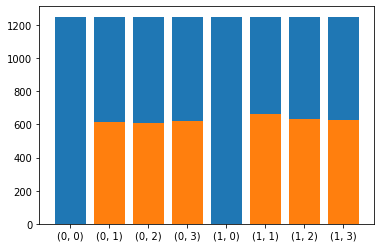

In [ ]:
#slow
#hide_input

p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_params = {'p1':p1, 'p2':p2}
w_params = {'p_max': [0.5,0.5], 'delta_max': [0.1,0.5]}

ss = SubsetSamplerDiagnostic(ghz,err_params,w_params,subset_select_fn=uniform_select)
fail_counts, counts = ss.run(n_samples=10000)
weights = ss.w_vecs

x = range(len(counts))
plt.bar(x, counts)
plt.bar(x, fail_counts)
plt.xticks(x, weights);

Setup sampling of partitions ['p1', 'p2'] with maximum fault weights [1, 3] and excluded weights set().


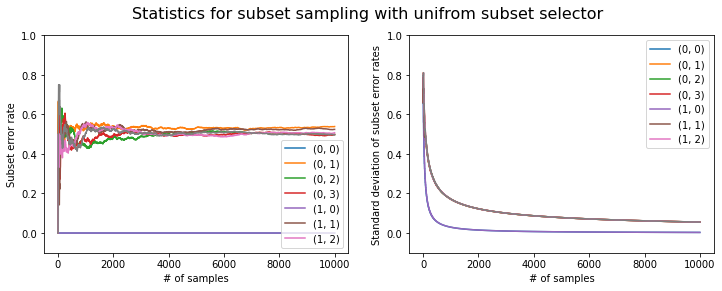

In [ ]:
#slow
#hide_input
ss = SubsetSamplerDiagnostic2(ghz,err_params,w_params,subset_select_fn=uniform_select)
fail_counts, counts = ss.run(n_samples=10000)
weights = ss.w_vecs

pws = fail_counts / counts
std = math.Wilson_std(pws, counts)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot((fail_counts/counts).T);
ax[0].set_xlabel('# of samples');
ax[0].set_ylabel('Subset error rate');
ax[0].legend(weights[:-1], loc='lower right');
ax[0].set_ylim([-0.1,1]);

ax[1].plot(std.T);
ax[1].set_xlabel('# of samples');
ax[1].set_ylabel('Standard deviation of subset error rates');
ax[1].legend(weights[:-1], loc='upper right');
ax[1].set_ylim([-0.1,1]);

fig.suptitle('Statistics for subset sampling with unifrom subset selector', fontsize=16);

Alternatively, we can make a decision which is more informed on a) the occurance probability of subsets (i.e. the binomial weights $A_w$) and the current as well as prospective variances for sampling respective subsets. Selecting the weight for which the difference scaled by $A_w^2$ yields a maximum is the best next subset weight we can choose in order to reduce the global variance the most. This method is termed Expected Reduction of Variance (ERV):

In [ ]:
show_doc(ERV_select)

<h4 id="ERV_select" class="doc_header"><code>ERV_select</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>ERV_select</code>(**`counts`**, **`fail_counts`**, **`Aw`**=*`1`*, **`var`**=*`Wilson_var`*, **\*`args`**, **\*\*`kwargs`**)

Return index of SS which yields maximum ERV

The sampling distribution for sampling with ERV selector yields:

Setup sampling of partitions ['p1', 'p2'] with maximum fault weights [1, 3] and excluded weights set().
Using p_phy_select ERV parameters: [0.1, 0.1]


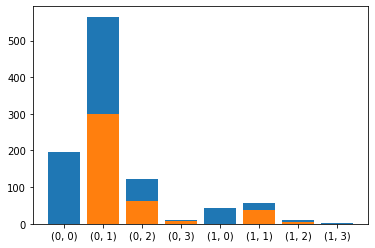

In [ ]:
#slow
#hide_input

p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_params = {'p1':p1, 'p2':p2}
w_params = {'p_max': [0.5,0.5], 'delta_max': [0.1,0.5]}

ss = SubsetSamplerDiagnostic(ghz,err_params,w_params,subset_select_fn=ERV_select)

p_phy_select = [0.1,0.1]
print(f"Using p_phy_select ERV parameters: {p_phy_select}")
fail_counts, counts = ss.run(n_samples=1000, p_phy_select=p_phy_select)
weights = ss.w_vecs

x = range(len(counts))
plt.bar(x, counts)
plt.bar(x, fail_counts)
plt.xticks(x, weights);

Setup sampling of partitions ['p1', 'p2'] with maximum fault weights [1, 3] and excluded weights set().


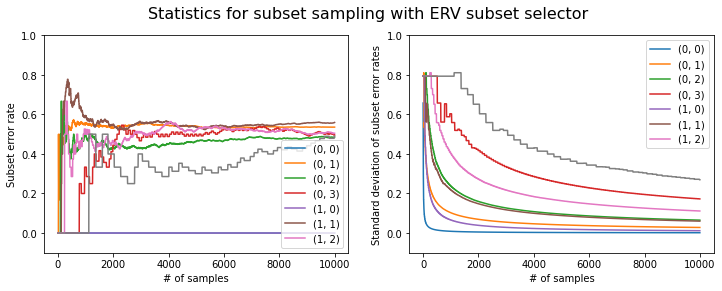

In [ ]:
#slow
#hide_input
ss = SubsetSamplerDiagnostic2(ghz,err_params,w_params,subset_select_fn=ERV_select)
fail_counts, counts = ss.run(n_samples=10000)
weights = ss.w_vecs

pws = fail_counts / counts
std = math.Wilson_std(pws, counts)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot((fail_counts/counts).T);
ax[0].set_xlabel('# of samples');
ax[0].set_ylabel('Subset error rate');
ax[0].legend(weights[:-1], loc='lower right');
ax[0].set_ylim([-0.1,1]);

ax[1].plot(std.T);
ax[1].set_xlabel('# of samples');
ax[1].set_ylabel('Standard deviation of subset error rates');
ax[1].legend(weights[:-1], loc='upper right');
ax[1].set_ylim([-0.1,1]);

fig.suptitle('Statistics for subset sampling with ERV subset selector', fontsize=16);

In [ ]:
show_doc(calc_w_max)

<h4 id="calc_w_max" class="doc_header"><code>calc_w_max</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_w_max</code>(**`p_max`**, **`delta_max`**, **`n_partition_elems`**)

Calculate weight cutoff at p_max for delta_max

Let's look at how $w_{max}$ is selected for differen $p_{max}$ and $\delta_{max}$.

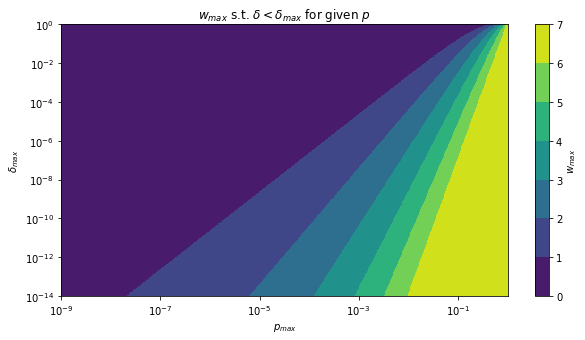

In [ ]:
#slow
#hide_input
n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

In [ ]:
show_doc(calc_subset_occurances)

<h4 id="calc_subset_occurances" class="doc_header"><code>calc_subset_occurances</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_subset_occurances</code>(**`partitions`**, **`partition_weight_vecs`**, **`p_phys_mat`**)

Calculate 3D tensor of binom. coefficients for each partition

Let's take a look at how the subset occurance for our example GHZ preparation circuit changes for the single parameter case and for varying physical error rates

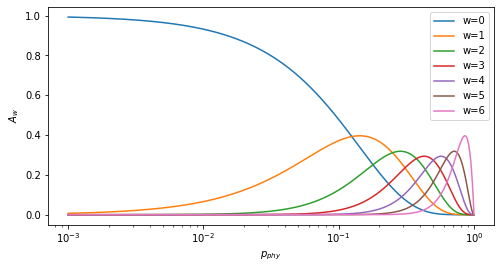

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

We can clearly see that the larger weight subsets only become relevant for relatively large physical error rates. We also see that the 0-fault-weight subset becomes enourmous relevant at low $p_{phy}$, so we gain a lot by excluding its sampling to begin with. Exluding the 0-weight subset from sampling we see following relevance:

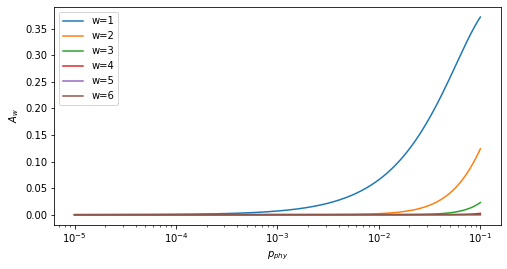

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-5, -1, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(1,len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(1,len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

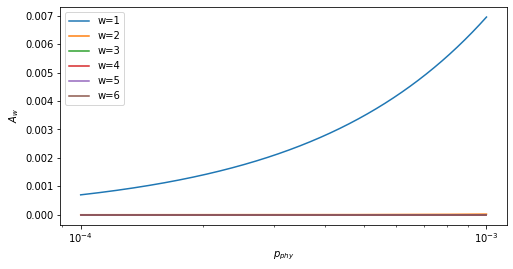

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-4, -3, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(1,len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(1,len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

And for the multi-parameter case:

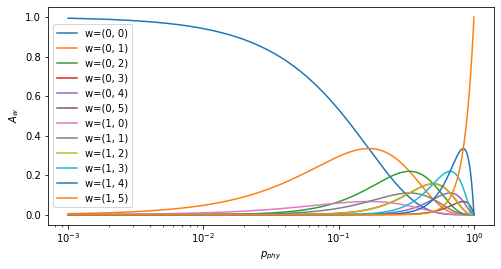

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = calc_subset_occurances(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

Zooming in and ignoring the (0,0) subset:

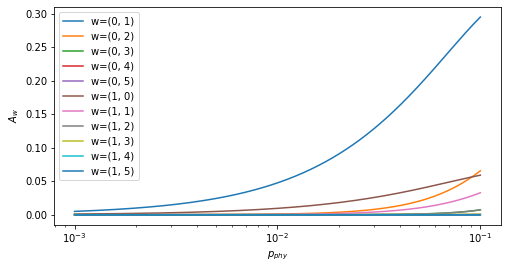

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, -1, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = calc_subset_occurances(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T[:,1:], label=[f'w={i}' for i in w_vecs[1:]]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

We can see that the (0,1) subset has the largest contribution to $p_L$ and that the (1,0)-subset only after about $0.1$ becomes the second most relevant subset, followed by (0,2) which exponentially decays and becomes on par with the heigher weight subsets.